In [1]:
import os
os.chdir('..')

# Set up environment

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pickle
import pandas_market_calendars as mcal
from tqdm import tqdm
import torch
torch.set_float32_matmul_precision('high')
from gymnasium import spaces
from mmd.env import GenLSTM, MMDSimulator, load_generator
from mmd.train import start_writer, get_params_from_events, get_params_dicts, get_robustq_params_dicts, train_robustdqn, training_info
from mmd.evaluation import simulate_agent_spx, generate_graph
from agent.q import QFunc
from agent.DQN import PORDQN

seed = 0 # results in the paper used 0, 1, 2, 3, 4

total_length = 560
burn_in = 500
state_len = 60
cal_start_date = '1995-01-01'
cal_end_date = '2023-12-31'
trading_calendar = 'NYSE'
calendar = mcal.get_calendar(trading_calendar)
schedule = calendar.schedule(start_date=cal_start_date, end_date=cal_end_date)

int_rate = 0.024
trans_cost = 0.0005 # standard cost = 0.0005
eval_batch_size = 1000
eval_seed = 12345

torch.manual_seed(seed)
batch_size = 8
device = 'cpu'
action_space = spaces.Discrete(9)
action_values = torch.linspace(-1., 1., 9, device=device)
num_actions = len(action_values)
nu_dist = 't'
nu_scale = 0.03
nu_df = 2
other_state_vars = ['log_wealth', 'positions', 'dt']
obs_dim = state_len + len(other_state_vars)

In [4]:
# RUN IF TRAINING FROM SCRATCH
discount = 0.99
eps_greedy = 0.1 # epsilon greedy parameter
buffer_max_length = int(1e5)
clone_steps = 50
train_steps = 1
agent_batch_size = 128
n_batches = 1
n_epochs = 1
robustq_lr = 1e-4
architecture = [64, 64]
pre_train_Q = False
n_episodes = 3

robustq = QFunc(state_len+len(other_state_vars), architecture, action_values.shape[0]).to(device)

delta = 1e-4 # regularisation parameter for Sinkhorn distance
epsilon = 0.003 # Sinkhorn distance
norm_ord = 1
lamda_init = 0. # initial lambda
lamda_max_iter = 100
lamda_step_size = 10 # step size for learning rate scheduler
lamda_gamma = 0 # gamma for learning rate scheduler
lamda_lr = [0.04,0.2,0.3,0.5,0.8,1.5,3,100,1000,10000,100000]
n_outer = 1 # not used in this algorithm but used in logging by writer
n_inner = 1000 # number of samples from nu to calc inner expectations

simulator_params, model_params = get_robustq_params_dicts(vars().copy())
writer = None

robustdqn_agent = PORDQN(obs_dim, num_actions, discount, nu_scale, nu_df, action_values, epsilon, delta, n_inner, lamda_init,lamda_lr, lamda_max_iter, lamda_step_size, lamda_gamma, norm_ord, robustq, eps_greedy, buffer_max_length, clone_steps, train_steps, agent_batch_size, n_batches, n_epochs, robustq_lr, device=device, seed=seed, writer=writer)

## Evaluation

In [6]:
path = "txn_0.05/delta/0"
training_path = f"runs/{path}/"

all_params = training_info(training_path)

Value
24.0    3322
25.0    1526
31.0    1425
27.0    1316
29.0    1289
Name: count, dtype: int64

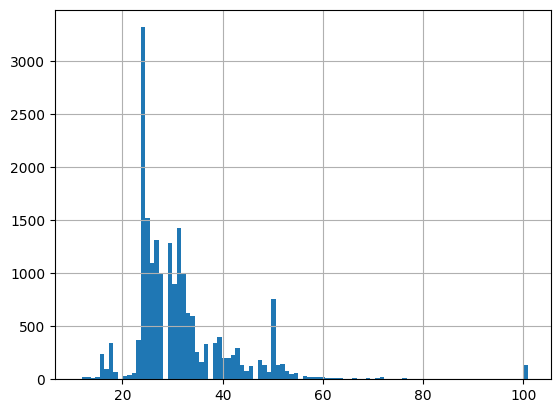

In [7]:
iters = all_params['Lambda/iterations']
iters['Value'].hist(bins=100)
iters['Value'].value_counts().head(5)
# iters['Value'].plot()

<Axes: >

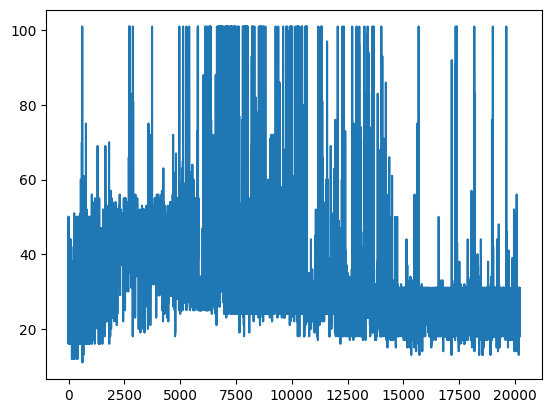

In [8]:
iters['Value'].plot()

<Axes: >

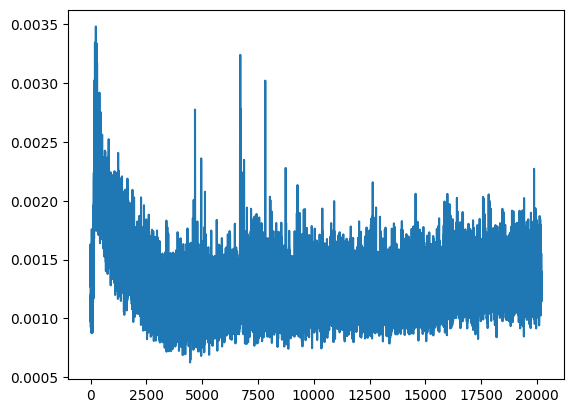

In [9]:
hq_delta = all_params['HQ/Mean_HQ_delta']
hq_delta['Value'].plot()

<Axes: >

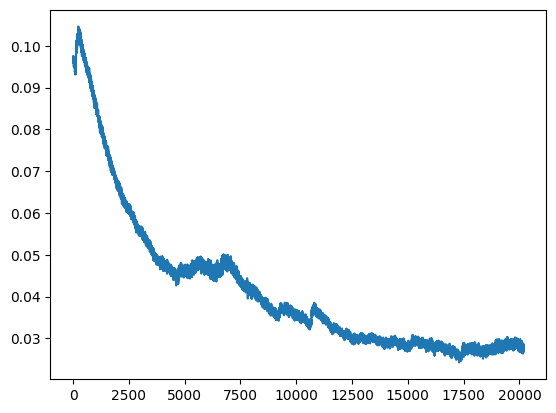

In [10]:
hq_val = all_params['HQ/mean_HQ_values']
hq_val['Value'].plot()

In [11]:
all_params['mean_cum_rewards']

,Value
1,1.049811
2,2.018951
3,2.599602


In [12]:
import random

checkpoint_path = f"{training_path}/checkpoint.pt"

checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=torch.device('cpu'))

robustdqn_agent.steps = checkpoint['agent_steps']
robustdqn_agent.q_updates = checkpoint['agent_q_updates']
robustdqn_agent.q.load_state_dict(checkpoint['agent_state_dict'])
robustdqn_agent.target_q.load_state_dict(checkpoint['agent_target_q'])
robustdqn_agent.optimizer.load_state_dict(checkpoint['agent_optimizer'])
robustdqn_agent.buffer = checkpoint['agent_buffer']
robustdqn_agent.rng.bit_generator.state = checkpoint['numpy_rng_state']
robustdqn_agent.epsilon = checkpoint['agent_eps_greedy']
random.setstate(checkpoint['random_state'])
torch.set_rng_state(checkpoint['torch_rng_state'])


In [13]:
simulate_agent_spx(robustdqn_agent.q, action_values, int_rate=int_rate, trans_cost=trans_cost)

{'final_wealth': 1.6921246694094387,
 'max_drawdown': -0.3984969240502543,
 'sharpe': 0.1574878568819609,
 'volatility': 0.11628085024123112,
 'down_deviation': 0.08488226032792731,
 'sortino': 0.21574380595139017,
 'spx_final_wealth': 9.524411783739737,
 'spx_max_drawdown': -0.5677538774277282,
 'spx_sharpe': 0.40986550593061494,
 'spx_volatility': 0.19130311470223205,
 'spx_down_deviation': 0.13779502078420072,
 'spx_sortino': 0.5690230855026872}

position
 0.00    4244
 0.75    2121
 1.00     495
 0.25     242
-0.25      66
 0.50      23
-0.50      23
-0.75      19
-1.00       6
Name: count, dtype: int64


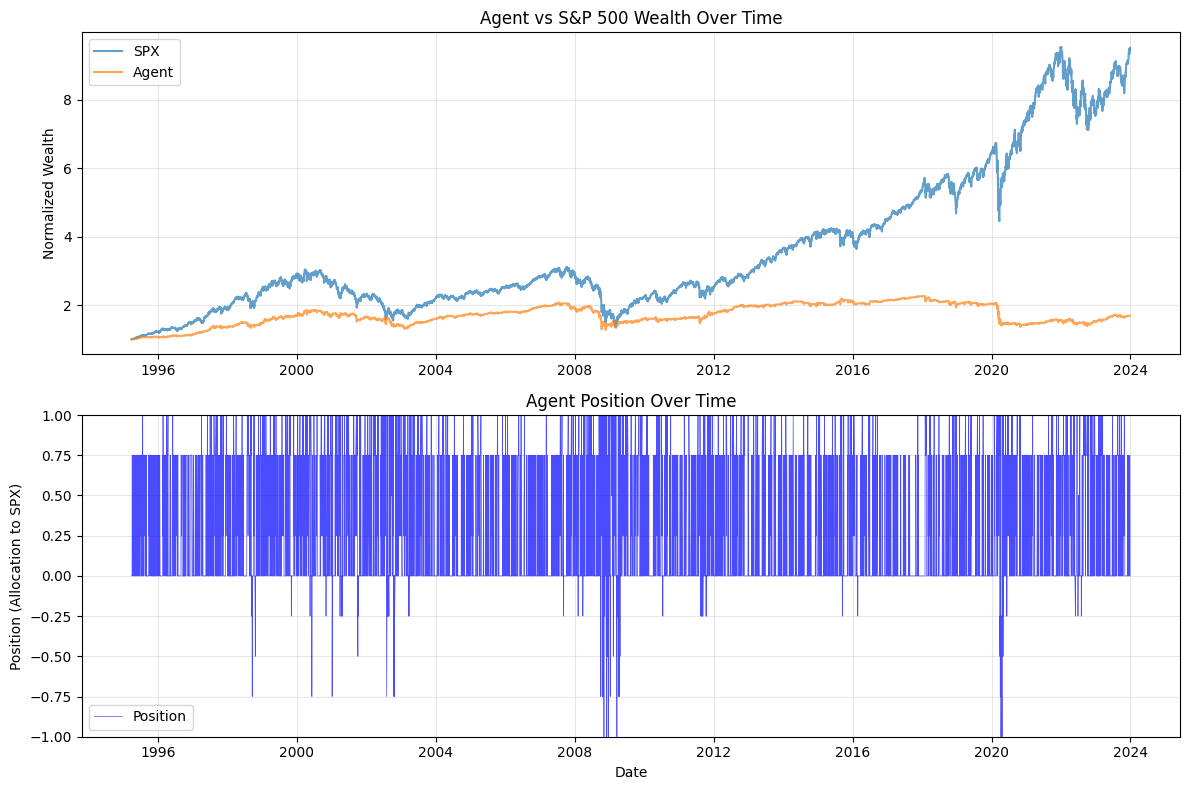

In [14]:
generate_graph(robustdqn_agent.q, action_values, int_rate=int_rate, trans_cost=trans_cost)